# Sentiment Classification: Comparing RNN, LSTM, and BERT
In this notebook, we will:
1. Explore sentiment classification using three different models:
   - Recurrent Neural Networks (RNN) (baseline)
   - Long Short-Term Memory (LSTM)
   - BERT (Bidirectional Encoder Representations from Transformers)
2. Compare their performance on a sentiment classification task using a small dataset.

By the end of this notebook, you will understand:
- How each model works.
- The strengths and weaknesses of RNN, LSTM, and BERT.
- How to implement and compare them.


## Step 1: Import Libraries
We need several libraries for this project, including:
- `tensorflow` for RNN and LSTM.
- `transformers` for BERT.
- `datasets` for loading a sentiment dataset.


In [1]:
%%capture
!pip install datasets

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense, Bidirectional
from transformers import BertTokenizer, TFBertForSequenceClassification
from datasets import load_dataset
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt


## Step 2: Load and Prepare Dataset
We will use the IMDb dataset, a standard benchmark for sentiment classification. The dataset contains movie reviews labeled as `positive` or `negative`.

### Steps:
1. Load the dataset using `datasets` library.
2. Split it into training and test sets.
3. Preprocess the text for RNN, LSTM, and BERT.


In [3]:
# Load IMDb dataset
data = load_dataset("imdb")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [4]:
# Print the overall structure of the dataset
print(data)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})


In [5]:
print(data['train'].features)


{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['neg', 'pos'], id=None)}


In [8]:
# Load a random sample from the training set
print(data['train'].shuffle(seed=22)[0])


{'text': 'Although the plot was a bit sappy at times, and VERY rushed at the end, as if the director had run out of his alloted time and needed to hurry up and finish the story, overall it was pretty good for the Made-For-Backwoods-Cable-TV genre. <br /><br />However, the actress who played the babysitter, Mariana Klaveno, was very good! I hope to see more of her around in movie-land. The music was also well done, getting every possible chill out of the dah-DUH-dah-DUH (think "JAWS") type music-based tension build-ups.<br /><br />I don\'t think I\'d want to watch "While the Children Sleep" again, but if I did, it would be to focus on the performance of the talented Klaveno.', 'label': 1}


In [9]:
train_texts, test_texts, train_labels, test_labels = train_test_split(
    data['train']['text'], data['train']['label'], test_size=0.2, random_state=42)

In [10]:
print(f"Training samples: {len(train_texts)}")
print(f"Test samples: {len(test_texts)}")

Training samples: 20000
Test samples: 5000


### Visualizing Dataset Samples

In [11]:
# Assuming train_texts is a list of strings and train_labels is a list of integers
print("Example 1:")
print(f"Text: {train_texts[0]}")
print(f"Label: {'Positive' if train_labels[0] == 1 else 'Negative'}")

print("\nExample 2:")
print(f"Text: {train_texts[1]}")
print(f"Label: {'Positive' if train_labels[1] == 1 else 'Negative'}")


Example 1:
Text: I borrowed this movie despite its extremely low rating, because I wanted to see how the crew manages to animate the presence of multiple worlds. As a matter of fact, they didn't - at least, so its seems. Some cameo appearance cut rather clumsily into the movie - that's it, this is what the majority of viewers think. However, the surprise comes at the end, and unfortunately then, when probably most of the viewers have already stopped this movie. I was also astonished when I saw that the Brazilian-Portuguese title of this movie means "Voyage into Death". This is THE spoiler.<br /><br />That this movie is about a young girl who goes ALONE onto this boat (on reasons that are completely unclear), you understand only in the last 5 minutes. When you start the movie with the English title "Haunted Boat" in your head, you clearly think that the cameo appearances of strange figures are the "ghosts". But in reality, this movie is not like most other horror movies told from the di

## Preprocessing for Deep learning

In [12]:


# Tokenize for RNN and LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


# The Tokenizer is a utility that processes text and assigns an integer (token) to each unique word

tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>") # num_words=10000 Limits the vocabulary size to the top 10,000 most frequent words in the dataset. The "out of vocabulary" token is used for words that are not in the top 10,000.

# The fit_on_texts method processes the train_texts (a list of text samples, like movie reviews) and builds a word index.
tokenizer.fit_on_texts(train_texts)




In [13]:
# Converts the text data (train_texts and test_texts) into numerical sequences using the Tokenizer object.
train_sequences = tokenizer.texts_to_sequences(train_texts)
train_padded = pad_sequences(train_sequences, maxlen=100, truncating='post')

test_sequences = tokenizer.texts_to_sequences(test_texts)
test_padded = pad_sequences(test_sequences, maxlen=100, truncating='post')

In [14]:

#  Suppose the word_index looks like this:
{'<OOV>': 1, 'i': 2, 'love': 3, 'this': 4, 'movie': 5, 'the': 6, 'acting': 7, 'was': 8, 'great': 9}



{'<OOV>': 1,
 'i': 2,
 'love': 3,
 'this': 4,
 'movie': 5,
 'the': 6,
 'acting': 7,
 'was': 8,
 'great': 9}

In [15]:
# After converting the text into sequences:
train_sequences = [
    [2, 3, 4, 5],        # "I love this movie"
    [6, 7, 8, 9]         # "The acting was great"
]


## Step 3: Baseline Model - RNN
The first model we’ll use is a **RNN**:
## Implementing an RNN for Sentiment Classification
### Key Points:
1. **Why RNN?**
   - RNNs process sequences of data (e.g., text) one token at a time.
   - They use a "hidden state" to remember information about previous tokens, making them suitable for tasks like sentiment analysis.

2. **Model Architecture**:
   - **Embedding Layer**: Converts words into dense vectors of fixed size.
   - **RNN Layer**: Processes the sequence of embeddings one token at a time.
   - **Dense Layer**: Outputs a probability for positive or negative sentiment.

3. **Limitations of RNN**:
   - Struggles to capture long-term dependencies (e.g., words at the beginning influencing words at the end).
   - Training can be slow due to sequential processing.

Let’s build and train an RNN.



What Does 10000 Do in the Model?

The 10000 specifies that:

The Embedding layer will maintain an embedding matrix of shape (10000, 64), where:

Rows: Correspond to the 10,000 words in the vocabulary.

Columns: Represent the 64-dimensional embedding for each word.

When a token is passed to the Embedding layer, it looks up the corresponding row in the embedding matrix and retrieves the dense vector for that token.

In [16]:
model_rnn = Sequential([

    Embedding(10000, 64, input_length=100),  # Converts words into dense vectors
    SimpleRNN(64),  # Processes the sequence one token at a time
    Dense(1, activation='sigmoid')  # Outputs sentiment (0: negative, 1: positive)
])

model_rnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print("Training RNN...")
history_rnn = model_rnn.fit(
    train_padded, np.array(train_labels),
    epochs=5, validation_data=(test_padded, np.array(test_labels))
)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Training RNN...
Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.5034 - loss: 0.6963 - val_accuracy: 0.5062 - val_loss: 0.6927
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.6062 - loss: 0.6730 - val_accuracy: 0.6678 - val_loss: 0.6094
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.6687 - loss: 0.6174 - val_accuracy: 0.6078 - val_loss: 0.6739
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.7962 - loss: 0.4397 - val_accuracy: 0.7448 - val_loss: 0.5499
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.9053 - loss: 0.2486 - val_accuracy: 0.7634 - val_loss: 0.6096


## Step 4: Improved Model - LSTM
The **Long Short-Term Memory (LSTM)** model improves on RNNs:
## Implementing an LSTM for Sentiment Classification
### Key Points:
1. **Why LSTM?**
   - Long Short-Term Memory (LSTM) networks are a type of RNN designed to handle long-term dependencies.
   - They use **gates** to control the flow of information:
     - **Forget Gate**: Discards irrelevant information.
     - **Input Gate**: Decides what new information to store.
     - **Output Gate**: Outputs relevant information for the current step.

2. **Model Architecture**:
   - Similar to the RNN, but replaces the RNN layer with a Bidirectional LSTM.
   - Bidirectional LSTM processes the sequence both forwards and backwards, improving context understanding.

3. **Advantages of LSTM**:
   - Handles long-term dependencies better than RNNs.
   - Reduces the vanishing gradient problem.

Let’s build and train an LSTM.



### Bidirectional LSTM
- **What Is a Bidirectional LSTM?**
  - A **Bidirectional LSTM** consists of two LSTMs:
    1. One processes the input sequence from **left-to-right**.
    2. The other processes the input sequence from **right-to-left**.
  - At each time step, the outputs of these two LSTMs are **combined** (e.g., concatenated or averaged).

- **What Does It Achieve?**
  - The left-to-right LSTM captures information from preceding tokens.
  - The right-to-left LSTM captures information from succeeding tokens.
  - Combining both directions allows the Bidirectional LSTM to consider both past and future tokens when making predictions.

- **Example**:
  For the sentence *"The bank of the river is calm"*:
  - The **left-to-right LSTM** sees: "The", "bank", "of", "the", "river".
  - The **right-to-left LSTM** sees: "calm", "is", "river", "the", "of".



In [17]:
model_lstm = Sequential([
    Embedding(10000, 64, input_length=100),  # Same embedding layer
    Bidirectional(LSTM(64)),  # Processes the sequence in both directions
    Dense(1, activation='sigmoid')  # Outputs sentiment (0: negative, 1: positive)
])

model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print("Training LSTM...")
history_lstm = model_lstm.fit(
    train_padded, np.array(train_labels),
    epochs=5, validation_data=(test_padded, np.array(test_labels))
)


Training LSTM...
Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.6667 - loss: 0.5744 - val_accuracy: 0.8260 - val_loss: 0.4122
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.8737 - loss: 0.3120 - val_accuracy: 0.8196 - val_loss: 0.4120
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.9286 - loss: 0.1947 - val_accuracy: 0.8174 - val_loss: 0.4496
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.9604 - loss: 0.1116 - val_accuracy: 0.8184 - val_loss: 0.5697
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9803 - loss: 0.0586 - val_accuracy: 0.7922 - val_loss: 0.6700


## Step 5: Advanced Model - BERT
BERT is a **pretrained transformer-based model** that:
- Understands context dynamically (e.g., "bank" as a financial institution or riverbank).
- Uses transfer learning for efficient fine-tuning on downstream tasks.

We’ll use Hugging Face's Transformers library to fine-tune BERT for sentiment classification.


In [18]:
bert_model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Purpose:

- Loads the pretrained BERT model with an additional classification head for fine-tuning on a binary classification task (sentiment analysis in this case).

Details:
- TFBertForSequenceClassification:
- A TensorFlow-specific version of BERT designed for sequence classification tasks.
- num_labels=2:
- Specifies that the model will classify inputs into two categories (positive or negative sentiment).

In [19]:
# Load the pretrained BERT tokenizer
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [20]:
# tokenize_data function to preprocess the input texts for the BERT model.
def tokenize_data(texts, tokenizer, max_length=128):
    return tokenizer(
        texts, max_length=max_length, padding="max_length", truncation=True, return_tensors="tf"
    )

train_encodings = tokenize_data(train_texts, bert_tokenizer)
test_encodings = tokenize_data(test_texts, bert_tokenizer)

In [21]:
# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings), np.array(train_labels)
)).batch(16)

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings), np.array(test_labels)
)).batch(16)

In [22]:
from transformers import create_optimizer

# Define number of training steps (adjust as needed)
num_train_steps = len(train_dataset) * 3  # total batches × epochs

# Create Hugging Face optimizer
optimizer, _ = create_optimizer(
    init_lr=2e-5,  # Learning rate
    num_warmup_steps=0,  # Optional warm-up steps
    num_train_steps=num_train_steps  # Total training steps
)


In [23]:
# Complie and Train model
bert_model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)


history_bert = bert_model.fit(train_dataset, epochs=3, validation_data=test_dataset)


Epoch 1/3
1250/1250 [==============================] - 606s 448ms/step - loss: 0.3398 - accuracy: 0.8477 - val_loss: 0.2718 - val_accuracy: 0.8830
Epoch 2/3
1250/1250 [==============================] - 557s 445ms/step - loss: 0.1727 - accuracy: 0.9319 - val_loss: 0.3271 - val_accuracy: 0.8866
Epoch 3/3
1250/1250 [==============================] - 554s 443ms/step - loss: 0.0842 - accuracy: 0.9708 - val_loss: 0.3722 - val_accuracy: 0.8898


## Step 6: Compare Results
We’ll compare the accuracy of RNN, LSTM, and BERT models.

### Metrics:
- **Train Accuracy**: Performance on the training set.
- **Validation Accuracy**: Generalization performance on unseen data.
- **Training Time**: Computational cost of training each model.


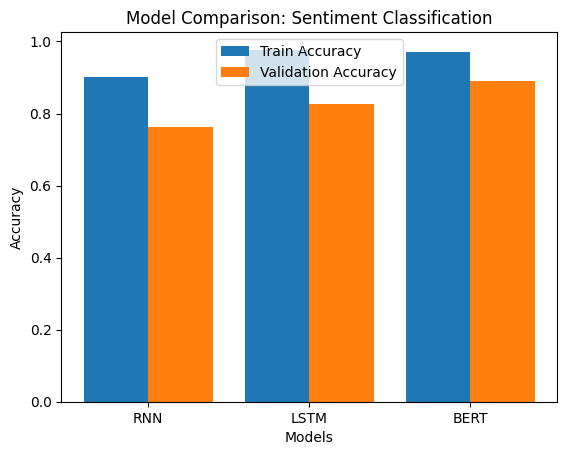

In [24]:
# Placeholder results
results = {
    "RNN": [max(history_rnn.history['accuracy']), max(history_rnn.history['val_accuracy'])],
    "LSTM": [max(history_lstm.history['accuracy']), max(history_lstm.history['val_accuracy'])],
    "BERT": [max(history_bert.history['accuracy']), max(history_bert.history['val_accuracy'])]
}

# Plot results
models = list(results.keys())
train_acc = [res[0] for res in results.values()]
val_acc = [res[1] for res in results.values()]

x = np.arange(len(models))
plt.bar(x - 0.2, train_acc, 0.4, label='Train Accuracy')
plt.bar(x + 0.2, val_acc, 0.4, label='Validation Accuracy')
plt.xticks(x, models)
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Model Comparison: Sentiment Classification")
plt.show()


# Conclusion
- RNN is simple but struggles with long-term dependencies.
- LSTM improves memory management, achieving better performance than RNN.
- BERT outperforms both on generalization but requires more computational resources.

### Key Takeaway:
Choose the model based on the **task size**, **dataset**, and **computational resources**.
